# MBA em Ciência de Dados - TCC
# Predição da Radiação Solar para Produção de Hidrogênio Verde: Análise comparativa de métodos de Aprendizado de Máquina

## Modelagem e Predição
**Material Produzido por:** Mateus Vasconcelos Albuquerque

**Cemeai - ICMC/USP São Carlos**


---------------------------------------------------------------------------------------------------------





## **CRISP-DS**

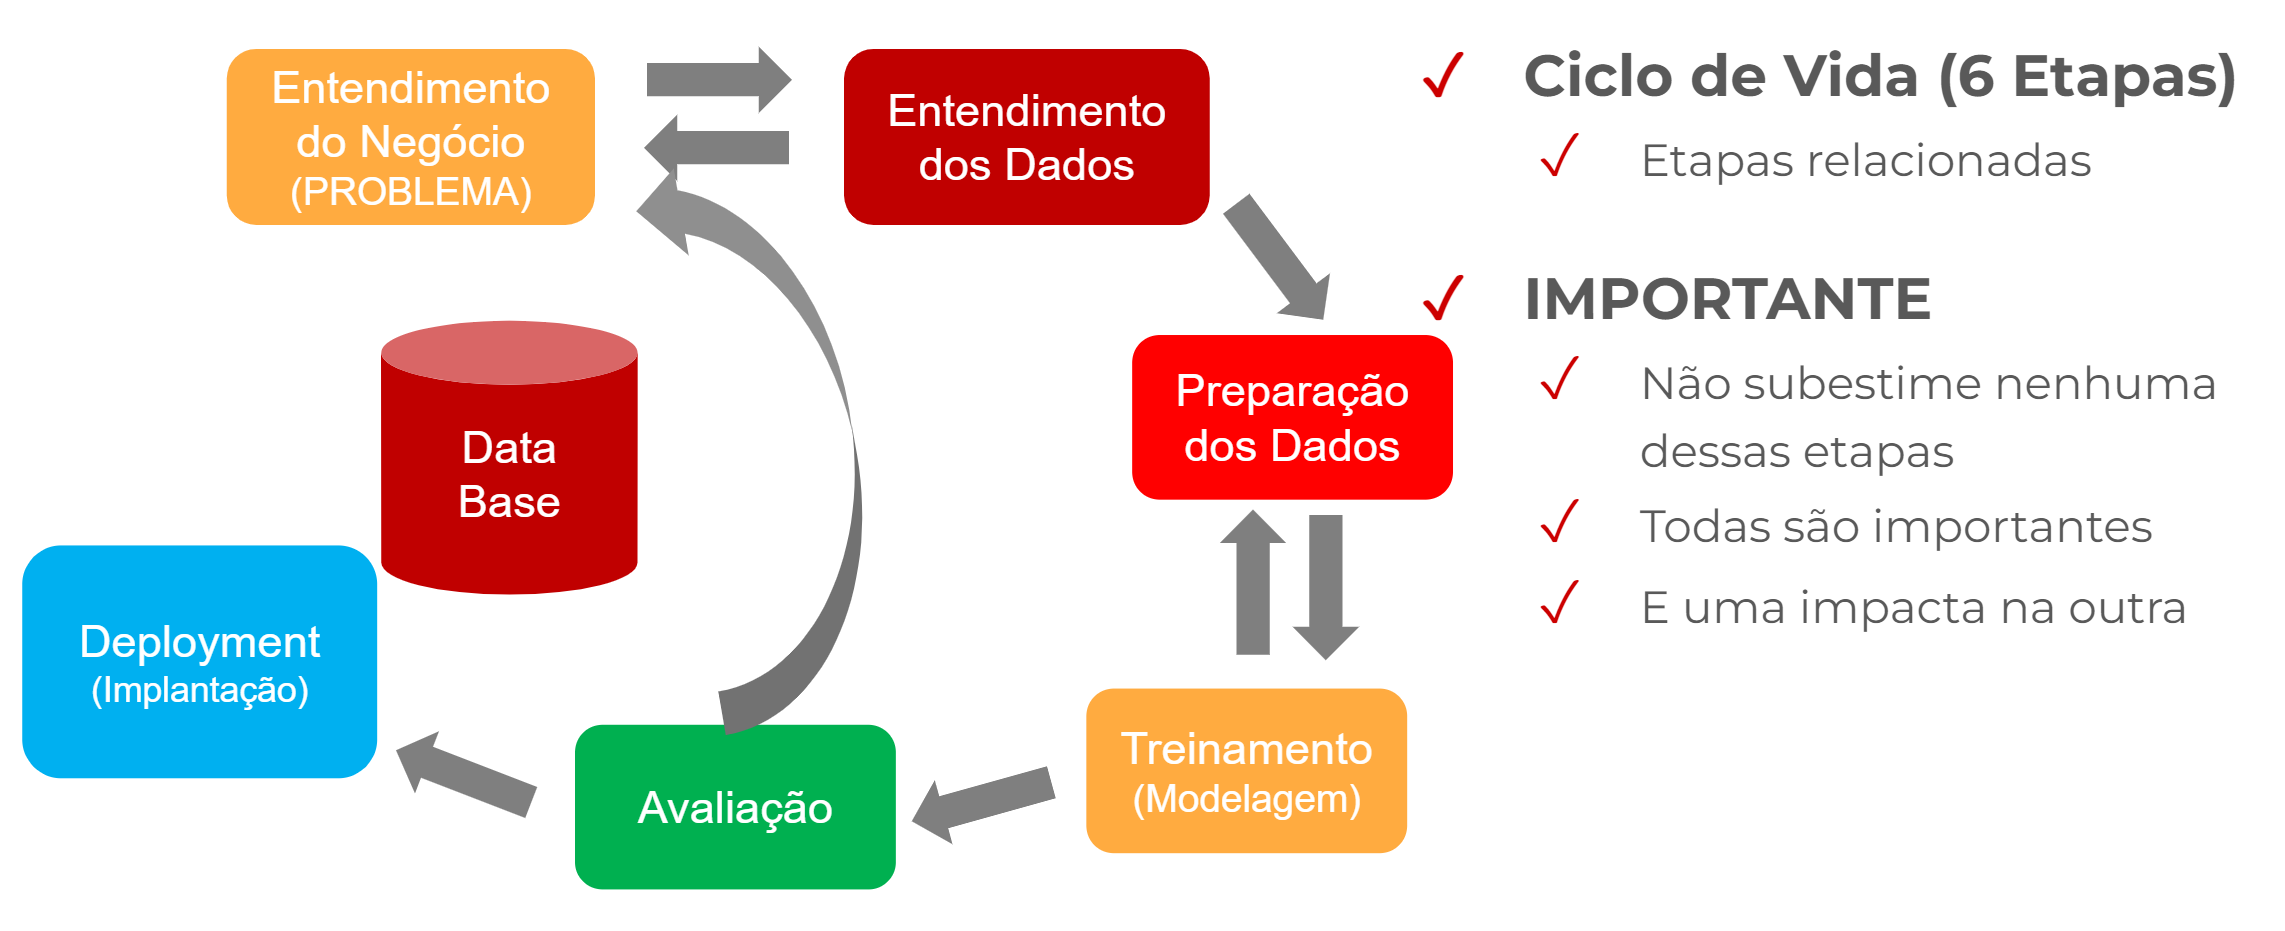

## **3. Preparação dos Dados**

### 3.1. Import dos dados pré-processados

In [1]:
import pandas as pd
from pandas.plotting import lag_plot
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import os

In [2]:
# Leitura do arquivo de configuração

# folder para carregar os config files
CONFIG_PATH = "config/"

# Função para carregar os dados
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

In [3]:
config = load_config("data_preprocessing_config_sobral.yaml")

# mostrar todas as colunas
pd.set_option("display.max_columns", None)

In [4]:
# Leitura dos dados a partir do CSV
codigo_wmo = config["input_data_parameters"]["codigo_wmo"]
estacao = config["input_data_parameters"]["estacao"]

input_dir = config["output_directory_preprocessing"]

filepath = f"{input_dir}/preprocessed_data_{codigo_wmo}_{estacao}.csv"

data = pd.read_csv(
    filepath,
    index_col=0,
)

### 3.2. Separação em treino e teste

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precipitacao_total_horario                 43824 non-null  float64
 1   pressao_atmosferica_nivel_estacao_horaria  43824 non-null  float64
 2   temperatura_ar_bulbo_seco_horaria          43824 non-null  float64
 3   umidade_relativa_ar_horaria                43824 non-null  float64
 4   vento_direcao_horaria                      43824 non-null  float64
 5   vento_rajada_maxima                        43824 non-null  float64
 6   vento_velocidade_horaria                   43824 non-null  float64
 7   radiacao_global                            43824 non-null  float64
 8   year                                       43824 non-null  int64  
 9   hora                                       43824 non-null  int64  


In [6]:
# Divisão treino e teste
holdout = 30 * 24
holdout = 7 * 24

train_data = data.iloc[: (len(data) - holdout)]
test_data = data.iloc[(len(data) - holdout) :]

In [7]:
variable = "radiacao_global"

In [8]:
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)

<Axes: >

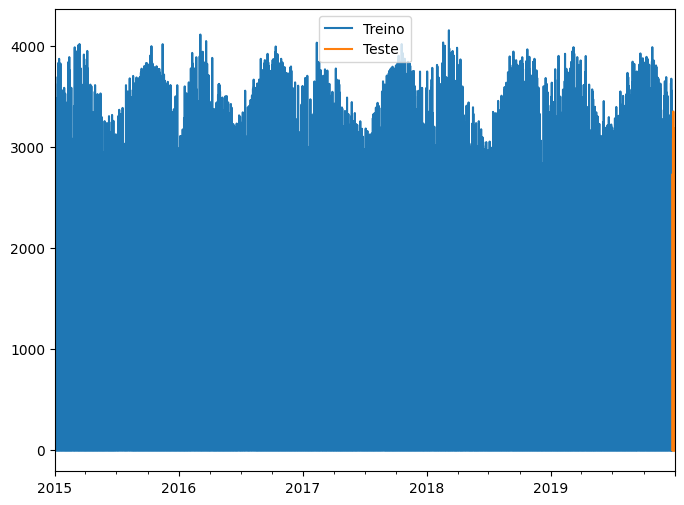

: 

In [ ]:
train_data[variable].plot(legend=True,label='Treino')
test_data[variable].plot(legend=True,label='Teste',figsize=(8,6))

## **4. Modelagem**

In [ ]:
# Previsão usando auto-arima
import pmdarima as pm

stepwise_fit = pm.auto_arima(
    train_data["radiacao_global"],
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    m=24,
    seasonal=True,
    trace=True,
    error_action="ignore",  # se uma ordem não convergir, ignorar
    suppress_warnings=True,  # ignorar avisos
    stepwise=True,
)  # executar stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=640348.549, Time=164.48 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=736757.285, Time=0.45 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=636217.682, Time=83.67 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=674202.022, Time=87.03 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=756065.022, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=658731.677, Time=1.11 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=729.61 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=206.18 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=647582.044, Time=110.59 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=922.29 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=134.43 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=636139.240, Time=202.18 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=647911.972, Time=1.83 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=855.63 sec
 ARIMA(2

In [ ]:
n = test_data.shape[0]

forecast, conf_interval = stepwise_fit.predict(
    n_periods=n, return_conf_int=True
)

lower_ci, upper_ci = zip(*conf_interval)

index = test_data.index

ax = test_data["radiacao_global"].plot(
    style="--", alpha=0.6, figsize=(12, 4)
)

pd.Series(forecast, index=index).plot(style='-', ax=ax)

plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)

plt.legend(['test', 'forecast']); plt.show()

In [ ]:
# Erros absolutos médios
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_sarima = mean_absolute_error(test_data["radiacao_global"], forecast)

rmse_sarima = np.sqrt(
    mean_squared_error(test_data["radiacao_global"], forecast)
)

mape_sarima = (
    np.mean(
        np.abs(
            (test_data["radiacao_global"] - forecast)
            / test_data["radiacao_global"]
        )
    )
    * 100
)

print(f"MAE: {mae_sarima}")
print(f"RMSE: {rmse_sarima}")
print(f"MAPE: {mape_sarima}")

# Salvar os resultados do forecast
output_dir = config["output_directory_forecast"]

output_path = f"{output_dir}/forecast_{codigo_wmo}_{estacao}.csv"

forecast_df = pd.DataFrame(
    {
        "data": index,
        "radiacao_global": forecast,
        "lower_ci": lower_ci,
        "upper_ci": upper_ci,
    }
)

forecast_df.to_csv(output_path, index=False)

Não está funcionando com a base inteira. Abaixo teste com base menor

### 3.2. Separação em treino e teste

## **3. Preparação dos Dados 2 - SARIMA Reduzido**

### 3.1 Padronização dos dados

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train_data[[variable]])

scaled_train = scaler.transform(train_data[[variable]])
scaled_test = scaler.transform(test_data[[variable]])

In [11]:
# Convertendo para DataFrame com os índices originais
scaled_train_df = pd.DataFrame(scaled_train, index=train_data.index, columns=[variable])
scaled_test_df = pd.DataFrame(scaled_test, index=test_data.index, columns=[variable])

In [12]:
scaled_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43104 entries, 2015-01-01 00:00:00 to 2019-12-01 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   radiacao_global  43104 non-null  float64
dtypes: float64(1)
memory usage: 673.5 KB


In [13]:
# últimos 25% dos dados de scaled_train_df
scaled_train_df_red = scaled_train_df.iloc[int(len(scaled_train_df)*0.75):]

In [14]:
scaled_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43104 entries, 2015-01-01 00:00:00 to 2019-12-01 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   radiacao_global  43104 non-null  float64
dtypes: float64(1)
memory usage: 673.5 KB


In [15]:
scaled_train_df_red.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10776 entries, 2018-09-09 00:00:00 to 2019-12-01 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   radiacao_global  10776 non-null  float64
dtypes: float64(1)
memory usage: 168.4 KB


<Axes: >

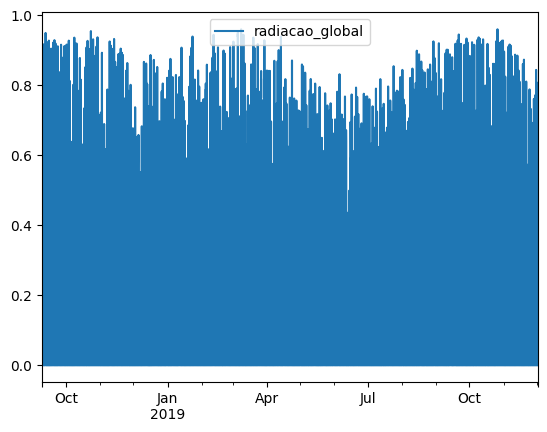

In [16]:
scaled_train_df_red.plot()

## **4. Modelagem 2 - SARIMA Reduzido**

In [17]:
# Previsão usando auto-arima
import pmdarima as pm

stepwise_fit = pm.auto_arima(
    scaled_train_df_red["radiacao_global"],
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    m=24,
    seasonal=True,
    trace=True,
    error_action="ignore",  # se uma ordem não convergir, ignorar
    suppress_warnings=True,  # ignorar avisos
    stepwise=True,
)  # executar stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=75.18 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2586.278, Time=0.88 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-22582.405, Time=63.19 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-13239.954, Time=33.15 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=7375.209, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-16793.072, Time=0.80 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=311.21 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=74.76 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-19679.933, Time=41.18 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=332.83 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=23.74 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-22596.987, Time=84.94 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-19574.385, Time=0.71 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=349.13 sec
 ARIMA(2,0,0)(1,0,1)[24]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                10776
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood               11303.494
Date:                            Tue, 07 Jan 2025   AIC                         -22596.987
Time:                                    17:40:05   BIC                         -22560.562
Sample:                                09-09-2018   HQIC                        -22584.703
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0153      0.001     11.262      0.000       0.013       0.018
ar.L1          0.6537      0.005    120.078      0.000       0.643       0.664
ar.L2          0.0416      0.006      7.334      0.000       0.030       0.053
ar.S.L24       0.7514      0.005    139.084      0.000       0.741       0.762
sigma2         0.0072   5.81e-05    123.664      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             24846.81
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
predito_arima = stepwise_fit.predict(
    scaled_test_df.shape[0]
)  # predict N steps into the future

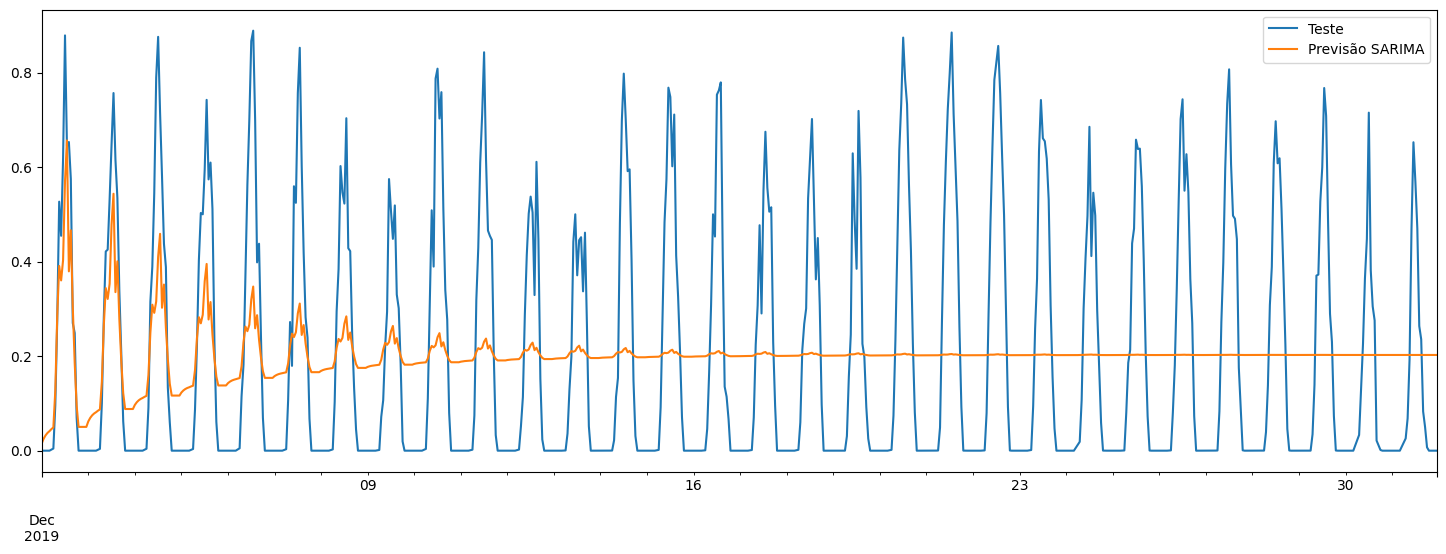

In [19]:
# Plots dos resultados ampliados no teste
plt.rcParams["figure.figsize"] = [18, 6]
scaled_test_df["radiacao_global"].plot(legend=True, label="Teste")
predito_arima.plot(legend=True, label="Previsão SARIMA")

plt.show()

In [20]:
# Erros absolutos médios
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae_sarima = mean_absolute_error(scaled_test_df["radiacao_global"], predito_arima)
rmse_sarima = np.sqrt(mean_squared_error(scaled_test_df["radiacao_global"], predito_arima))
mape_sarima = mean_absolute_percentage_error(scaled_test_df["radiacao_global"], predito_arima)

In [21]:
mae_sarima

0.20361520888083606